In [1]:
pip install openmeteo_requests

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install requests_cache

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install retry_requests

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install folium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import openmeteo_requests
import matplotlib.pyplot as plt
import requests_cache
import numpy as np
import pandas as pd
from retry_requests import retry
import folium

In [6]:
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [7]:
url_climate = "https://climate-api.open-meteo.com/v1/climate"
params_climate = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2022-08-04",
	"end_date": "2024-02-15",
	"models": "EC_Earth3P_HR",
	"timezone": "America/New_York",
	"daily": "temperature_2m_mean"
}
responses_climate = openmeteo.weather_api(url_climate, params=params_climate)

In [8]:
response = responses_climate[0]
# print(f"Coordinates {response.Latitude()}Â°N {response.Longitude()}Â°E")
# print(f"Elevation {response.Elevation()} m asl")
# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
# print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

daily_climate = response.Daily()
daily_temperature_2m_mean = daily_climate.Variables(0).ValuesAsNumpy()

daily_data_climate = {"date": pd.date_range(
	start = pd.to_datetime(daily_climate.Time(), unit = "s"),
	end = pd.to_datetime(daily_climate.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily_climate.Interval()),
	inclusive = "left"
)}
daily_data_climate["temperature_2m_mean"] = daily_temperature_2m_mean

daily_dataframe_climate = pd.DataFrame(data = daily_data_climate)
# print(daily_dataframe_climate)

In [9]:
url_co2 = "https://air-quality-api.open-meteo.com/v1/air-quality"
params_co2 = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"hourly": "carbon_monoxide",
	"timezone": "America/New_York",
	"start_date": "2022-08-04",
	"end_date": "2024-02-15",
	"domains": "cams_global"
}

responses_co2 = openmeteo.weather_api(url_co2, params=params_co2)
response = responses_co2[0]

In [10]:
hourly_co2 = response.Hourly()
hourly_carbon_monoxide = hourly_co2.Variables(0).ValuesAsNumpy()

hourly_data_co2 = {"date": pd.date_range(
	start = pd.to_datetime(hourly_co2.Time(), unit = "s"),
	end = pd.to_datetime(hourly_co2.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly_co2.Interval()),
	inclusive = "left"
)}
hourly_data_co2["carbon_monoxide"] = hourly_carbon_monoxide

hourly_dataframe_co2 = pd.DataFrame(data = hourly_data_co2)
# print(hourly_dataframe_co2)


In [11]:
url_sea_level = "https://marine-api.open-meteo.com/v1/marine"
params_sea_level = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"hourly": "wave_height",
	"timezone": "America/New_York",
	"start_date": "2022-08-04",
	"end_date": "2024-02-15"
}
responses_sea_level = openmeteo.weather_api(url_sea_level, params=params_sea_level)
response = responses_sea_level[0]

In [12]:
hourly_sea_level = response.Hourly()
hourly_wave_height = hourly_sea_level.Variables(0).ValuesAsNumpy()

hourly_data_sea_level = {"date": pd.date_range(
	start = pd.to_datetime(hourly_sea_level.Time(), unit = "s"),
	end = pd.to_datetime(hourly_sea_level.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly_sea_level.Interval()),
	inclusive = "left"
)}
hourly_data_sea_level["wave_height"] = hourly_wave_height

hourly_dataframe_sea_level = pd.DataFrame(data = hourly_data_sea_level)
# print(hourly_dataframe_sea_level)

temperature_change = np.diff(daily_dataframe_climate['temperature_2m_mean'])

co2_change = np.diff(hourly_dataframe_co2['carbon_monoxide'])


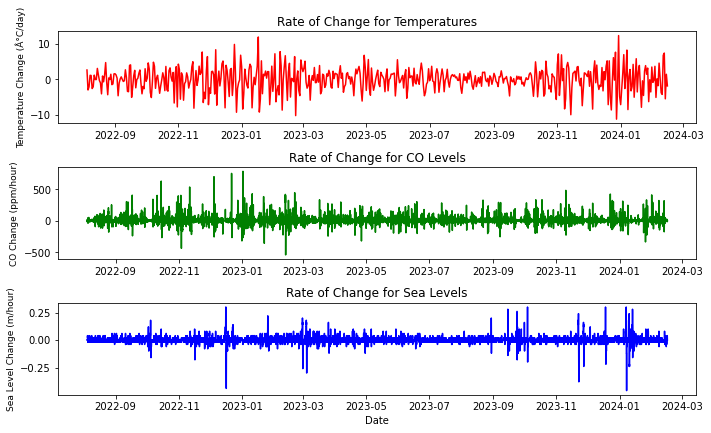

In [13]:
sea_level_change = np.diff(hourly_dataframe_sea_level['wave_height'])

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(daily_dataframe_climate['date'][1:], temperature_change, color='red')
plt.title('Rate of Change for Temperatures')
plt.ylabel('Temperature Change (Â°C/day)', fontsize = 9)

plt.subplot(3, 1, 2)
plt.plot(hourly_dataframe_co2['date'][1:], co2_change, color='green')
plt.title('Rate of Change for CO Levels')
plt.ylabel('CO Change (ppm/hour)', fontsize = 9)

plt.subplot(3, 1, 3)
plt.plot(hourly_dataframe_sea_level['date'][1:], sea_level_change, color='blue')
plt.title('Rate of Change for Sea Levels')
plt.ylabel('Sea Level Change (m/hour)', fontsize = 9)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [14]:
hourly_dataframe_co2['date'] = pd.to_datetime(hourly_dataframe_co2['date'])
daily_co2 = hourly_dataframe_co2.groupby(hourly_dataframe_co2['date'].dt.date).mean().reset_index()

temperature_change = np.diff(daily_dataframe_climate['temperature_2m_mean'])

co2_change = np.diff(daily_co2['carbon_monoxide'])
co2_change = co2_change[:-1]

correlation = np.corrcoef(co2_change, temperature_change)[0, 1]
print("Correlation between CO emission levels and global temperature changes:", correlation)

daily_dataframe_climate['year'] = daily_dataframe_climate['date'].dt.year
mean_temp_by_year = daily_dataframe_climate.groupby('year')['temperature_2m_mean'].mean()
yearly_change = mean_temp_by_year.diff()

Correlation between CO emission levels and global temperature changes: -0.0004610826090966426


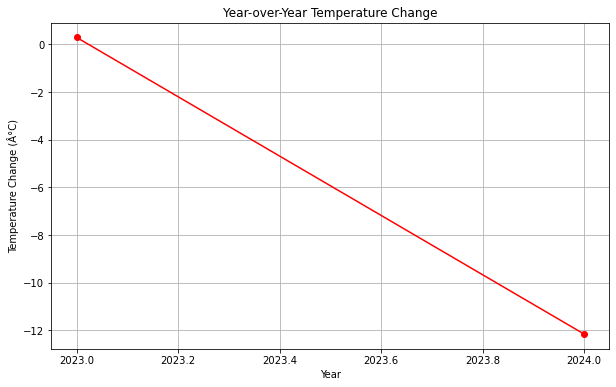

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_change.index[1:], yearly_change.values[1:], marker='o', color='red')
plt.title('Year-over-Year Temperature Change')
plt.xlabel('Year')
plt.ylabel('Temperature Change (Â°C)')
plt.grid(True)
plt.show()

In [16]:
map_climate_impacts = folium.Map(location=[40.7143, -74.006], zoom_start=10)

folium.Marker(location=[40.7143, -74.006], popup='New York City - High Temperature Change').add_to(map_climate_impacts)
folium.Marker(location=[41.8781, -87.6298], popup='Chicago - Moderate Temperature Change').add_to(map_climate_impacts)
folium.Marker(location=[34.0522, -118.2437], popup='Los Angeles - Low Temperature Change').add_to(map_climate_impacts)

map_climate_impacts

# GUI

In [17]:
pip install PyQt5

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
from PySide2 import QtWidgets

In [19]:
class Ui_MainWindow(object):
    def setupUi(self, MainWindow):
        MainWindow.setObjectName("MainWindow")
        MainWindow.resize(741, 402)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
        self.centralwidget.setObjectName("centralwidget")
        self.tempBtn = QtWidgets.QPushButton(self.centralwidget)
        self.tempBtn.setGeometry(QtCore.QRect(20, 60, 241, 31))
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(10)
        self.tempBtn.setFont(font)
        self.tempBtn.setAutoFillBackground(False)
        self.tempBtn.setObjectName("tempBtn")
        self.co2Btn = QtWidgets.QPushButton(self.centralwidget)
        self.co2Btn.setGeometry(QtCore.QRect(20, 140, 241, 31))
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(10)
        self.co2Btn.setFont(font)
        self.co2Btn.setObjectName("co2Btn")
        self.seaBtn = QtWidgets.QPushButton(self.centralwidget)
        self.seaBtn.setGeometry(QtCore.QRect(20, 100, 241, 31))
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(10)
        self.seaBtn.setFont(font)
        self.seaBtn.setObjectName("seaBtn")
        self.label = QtWidgets.QLabel(self.centralwidget)
        self.label.setGeometry(QtCore.QRect(20, 10, 261, 41))
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(18)
        font.setBold(True)
        font.setWeight(75)
        self.label.setFont(font)
        self.label.setFrameShape(QtWidgets.QFrame.NoFrame)
        self.label.setObjectName("label")
        self.outputLabel = QtWidgets.QLabel(self.centralwidget)
        self.outputLabel.setGeometry(QtCore.QRect(290, 10, 441, 371))
        self.outputLabel.setFrameShape(QtWidgets.QFrame.Box)
        self.outputLabel.setText("")
        self.outputLabel.setObjectName("outputLabel")
        self.outputLabel.setFont(font)
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(13)
        font.setBold(True)
        font.setWeight(75)
        self.correlationBtn = QtWidgets.QPushButton(self.centralwidget)
        self.correlationBtn.setGeometry(QtCore.QRect(20, 210, 241, 41))
        sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Fixed)
        sizePolicy.setHorizontalStretch(0)
        sizePolicy.setVerticalStretch(0)
        sizePolicy.setHeightForWidth(self.correlationBtn.sizePolicy().hasHeightForWidth())
        self.correlationBtn.setSizePolicy(sizePolicy)
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(10)
        self.correlationBtn.setFont(font)
        self.correlationBtn.setObjectName("correlationBtn")
        self.label_2 = QtWidgets.QLabel(self.centralwidget)
        self.label_2.setGeometry(QtCore.QRect(20, 180, 241, 16))
        self.label_2.setFrameShape(QtWidgets.QFrame.HLine)
        self.label_2.setFrameShadow(QtWidgets.QFrame.Plain)
        self.label_2.setText("")
        self.label_2.setObjectName("label_2")
        self.yearoverBtn = QtWidgets.QPushButton(self.centralwidget)
        self.yearoverBtn.setGeometry(QtCore.QRect(20, 260, 241, 41))
        sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Fixed)
        sizePolicy.setHorizontalStretch(0)
        sizePolicy.setVerticalStretch(0)
        sizePolicy.setHeightForWidth(self.yearoverBtn.sizePolicy().hasHeightForWidth())
        self.yearoverBtn.setSizePolicy(sizePolicy)
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(10)
        self.yearoverBtn.setFont(font)
        self.yearoverBtn.setObjectName("yearoverBtn")
        self.label_3 = QtWidgets.QLabel(self.centralwidget)
        self.label_3.setGeometry(QtCore.QRect(30, 360, 231, 16))
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(10)
        self.label_3.setFont(font)
        self.label_3.setObjectName("label_3")
        self.mapView = QtWebEngineWidgets.QWebEngineView(self.centralwidget)
        self.mapView.setGeometry(QtCore.QRect(290, 10, 441, 371))
        self.mapView.setUrl(QtCore.QUrl("about:blank"))
        self.mapView.setObjectName("mapView")
        self.mapBtn = QtWidgets.QPushButton(self.centralwidget)
        self.mapBtn.setGeometry(QtCore.QRect(20, 310, 241, 41))
        sizePolicy = QtWidgets.QSizePolicy(QtWidgets.QSizePolicy.Minimum, QtWidgets.QSizePolicy.Fixed)
        sizePolicy.setHorizontalStretch(0)
        sizePolicy.setVerticalStretch(0)
        sizePolicy.setHeightForWidth(self.mapBtn.sizePolicy().hasHeightForWidth())
        self.mapBtn.setSizePolicy(sizePolicy)
        font = QtGui.QFont()
        font.setFamily("Century Gothic")
        font.setPointSize(10)
        self.mapBtn.setFont(font)
        self.mapBtn.setObjectName("mapBtn")
        MainWindow.setCentralWidget(self.centralwidget)
        self.statusbar = QtWidgets.QStatusBar(MainWindow)
        self.statusbar.setObjectName("statusbar")
        MainWindow.setStatusBar(self.statusbar)

        self.retranslateUi(MainWindow)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)
        
        self.tempBtn.clicked.connect(self.tempFunc)
        self.seaBtn.clicked.connect(self.seaFunc)
        self.co2Btn.clicked.connect(self.co2Func)
        self.correlationBtn.clicked.connect(self.correlationFunc)
        self.yearoverBtn.clicked.connect(self.yearoverFunc)
        self.mapBtn.clicked.connect(self.mapFunc)

In [20]:
def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "Factors of Climate Change Using Python"))
        self.tempBtn.setText(_translate("MainWindow", "Temperature"))
        self.co2Btn.setText(_translate("MainWindow", "Carbon Dioxide"))
        self.seaBtn.setText(_translate("MainWindow", "Sea Level"))
        self.label.setText(_translate("MainWindow", "Rate of Change of :"))
        self.correlationBtn.setText(_translate("MainWindow", "Correlation : CO2 / Temperature"))
        self.yearoverBtn.setText(_translate("MainWindow", "Year over Year Comparision"))
        self.label_3.setText(_translate("MainWindow", "- By Aryan Mishra"))
        self.mapBtn.setText(_translate("MainWindow", "Climate Change Map"))
        self.outputLabel.setAlignment(QtCore.Qt.AlignCenter)
        self.mapView.hide()

In [21]:
 def tempFunc(self):
        self.mapView.hide()
        pixmap = QtGui.QPixmap("D:/Excel Stuff/Hackathon/Day_4/tempGraph.png") # Setup pixmap with the provided image
        pixmap = pixmap.scaled(self.outputLabel.width(), self.outputLabel.height(), QtCore.Qt.KeepAspectRatio) # Scale pixmap
        self.outputLabel.setPixmap(pixmap) # Set the pixmap onto the label
        self.outputLabel.setPixmap(pixmap) 

In [22]:
def co2Func(self):
        self.mapView.hide()
        pixmap = QtGui.QPixmap("D:\Excel Stuff\Hackathon\Day_4\co2Graph.png") # Setup pixmap with the provided image
        pixmap = pixmap.scaled(self.outputLabel.width(), self.outputLabel.height(), QtCore.Qt.KeepAspectRatio) # Scale pixmap
        self.outputLabel.setPixmap(pixmap) # Set the pixmap onto the label
        self.outputLabel.setPixmap(pixmap) 

In [23]:
 def seaFunc(self):
        self.mapView.hide()
        pixmap = QtGui.QPixmap("D:\Excel Stuff\Hackathon\Day_4\seaGraph.png") # Setup pixmap with the provided image
        pixmap = pixmap.scaled(self.outputLabel.width(), self.outputLabel.height(), QtCore.Qt.KeepAspectRatio) # Scale pixmap
        self.outputLabel.setPixmap(pixmap) # Set the pixmap onto the label
        self.outputLabel.setPixmap(pixmap)

In [24]:
def correlationFunc(self):
        self.mapView.hide()
        self.outputLabel.setText("Correlation between\nCO emission levels\nand global temperature changes:\n{}".format(mainfile.correlation))

In [25]:
def yearoverFunc(self):
        self.mapView.hide()
        pixmap = QtGui.QPixmap("D:\Excel Stuff\Hackathon\Day_4\yearoveryear.png") # Setup pixmap with the provided image
        pixmap = pixmap.scaled(self.outputLabel.width(), self.outputLabel.height(), QtCore.Qt.KeepAspectRatio) # Scale pixmap
        self.outputLabel.setPixmap(pixmap) # Set the pixmap onto the label
        self.outputLabel.setPixmap(pixmap) 

In [26]:
def mapFunc(self):
        self.mapView.setHtml(mainfile.map_climate_impacts.get_root().render())
        self.mapView.show()

In [ ]:
if __name__ == "__main__":
    import sys
    app = QtWidgets.QApplication(sys.argv)
    MainWindow = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(MainWindow)
    MainWindow.show()
    sys.exit(app.exec_())